## Exercises

In [2]:
# Prepare modules:
import numpy as np 
from scipy import stats
import pymc3 as pm
import arviz as az
import theano
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Exercise 1
Using PyMC3, change the parameters of the prior beta distribution
in our_first_model to match those of the previous chapter. Compare the
results to the previous chapter. Replace the beta distribution with a uniform one
in the interval [[0,1]]. Are the results equivalent to the Beta($\alpha$=1,$\beta$=1)? Is the
sampling slower, faster, or the same? What about using a larger interval such as
[[-1, 2]]? Does the model run? What errors do you get?



In [ ]:
import time
t0 = time.time()

#make data:
#Coin flip example data
np.random.seed(123)
trials = 4
theta_real = 0.35 #unknown value in real experiment
data = stats.bernoulli.rvs(p = theta_real, size = trials)

#Base model
with pm.Model() as our_first_model: 
    theta = pm.Beta("theta", alpha =1., beta = 1.) 
    y = pm.Bernoulli("y", p = theta, observed = data) 
    trace1 = pm.sample(1000, random_seed=123) 
    first_rt = time.time()-t0

t0 = time.time()

#Base model2
with pm.Model() as our_first_model2: 
    theta = pm.Beta("theta", alpha =20., beta = 20.) 
    y = pm.Bernoulli("y", p = theta, observed = data) 
    trace1 = pm.sample(1000, random_seed=123) 
    first_rt2 = time.time()-t0

t0 = time.time()

#Base model3
with pm.Model() as our_first_model3: 
    theta = pm.Beta("theta", alpha =1., beta = 4.) 
    y = pm.Bernoulli("y", p = theta, observed = data) 
    trace1 = pm.sample(1000, random_seed=123) 
    first_rt3 = time.time()-t0

t0 = time.time()

#new model1
with pm.Model() as our_second_model: 
    theta = pm.Uniform("theta" , lower = 0, upper = 1 ) 
    y = pm.Bernoulli("y", p = theta, observed = data) 
    trace2 = pm.sample(1000, random_seed=123) 
    second_rt = time.time()-t0

t0 = time.time()
#New model2
with pm.Model() as our_third_model: 
    theta = pm.Uniform("theta" , lower = -1, upper = 2 ) 
    y = pm.Bernoulli("y", p = theta, observed = data) 
    trace3 = pm.sample(1000, random_seed=123)
    third_rt = time.time()-t0 

print("\n Model runtimes: \n", first_rt,  second_rt,  third_rt, first_rt2, first_rt3)

## Exercise 2

Read about the coal mining disaster model that is part of the PyMC3
documentation: http:/​/​pymc-​devs.​github.​io/​pymc3/​notebooks/​getting_
started.​html#Case-​study-​2:-​Coal-​mining-​disasters. Try to implement and
run this model by yourself.

In [15]:
#create data

disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)

years = np.arange(1851, 1962)



In [16]:
#Good luck doing this without the tutorial:
with pm.Model() as disaster_model: #initiate model

    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1860
    ) # Discrete uniform prior that switches at 1900

    # Priors for pre- and post-switch rates number of disasters (i.e. later than 1900 - switchy boi go switch)
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

    trace = pm.sample(10000, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 48 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [13]:
az.summary(trace)

mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
switchpoint  1860.052  3.434  1851.000  1863.000      0.743    0.533   
early_rate      3.898  1.176     0.845     5.468      0.243    0.174   
late_rate       1.668  1.239     0.199     4.385      0.230    0.171   

             ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
switchpoint      21.0    21.0      47.0      50.0   1.08  
early_rate       23.0    23.0      43.0      45.0   1.06  
late_rate        29.0    27.0      50.0      92.0   1.06

array([[<AxesSubplot:title={'center':'switchpoint'}>,
        <AxesSubplot:title={'center':'switchpoint'}>],
       [<AxesSubplot:title={'center':'early_rate'}>,
        <AxesSubplot:title={'center':'early_rate'}>],
       [<AxesSubplot:title={'center':'late_rate'}>,
        <AxesSubplot:title={'center':'late_rate'}>]], dtype=object)

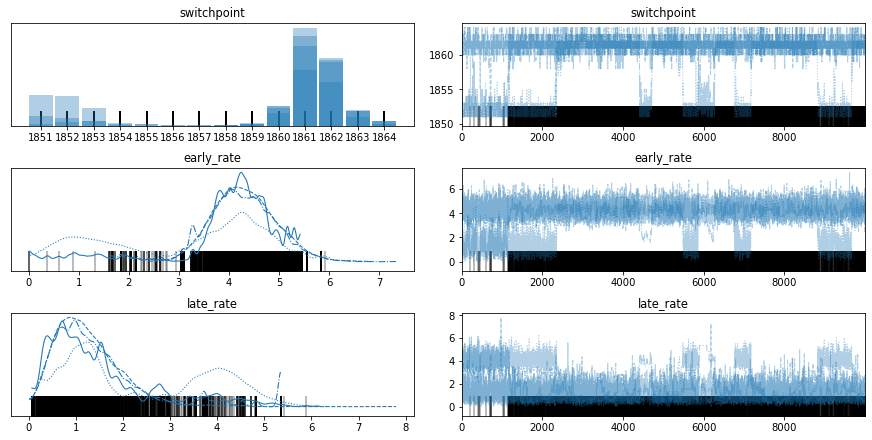

In [14]:
az.plot_trace(trace)

## Exercise 3

Modify model_g, change the prior for the mean to a Gaussian distribution
centered at the empirical mean, and play with a couple of reasonable values for
the standard deviation of this prior. How robust/sensitive are the inferences to
these changes? What do you think of using a Gaussian, which is an unbounded
distribution (goes from -∞ to ∞), to model bounded data such as this? Remember
that we said it is not possible to get values below 0 or above 100.

In [17]:
data = np.loadtxt('../data/chemical_shifts.csv')

with pm.Model() as model_g:
    μ = pm.Normal('μ', mu = data.mean(), sd = 10 ) #Victor: Pick higher. Mikkel: Pick lower! (or 30) (SD)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu = μ, sd=σ, observed=data)
    trace_g = pm.sample(1000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


## Exercise 4 - How to train your outliers

Using the data in the chemical_shifts.csv file, compute the empirical mean
and the standard deviation with and without outliers. Compare those results to
the Bayesian estimation using the Gaussian and Student's t-distribution. Repeat
the exercise by adding more outliers.

In [3]:
#Load data and build outlier rejection
data = np.loadtxt('../data/chemical_shifts.csv')
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

#With outliers:
mean_all = data.mean()
sd_all = data.std()

#Without outliers: 
data_clean = reject_outliers(data,m=2)
mean_out = data_clean.mean()
sd_out = data_clean.std()

print(mean_all, mean_out)
print(sd_all, sd_out)


53.49645833333333 52.95260869565218
3.4200063898474258 2.1950303897892387


In [4]:
# the normal model (very close to the mean for outlier data). 
with pm.Model() as chapter_mod:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data)
    trace_normal = pm.sample(1000)
az.summary(trace_normal)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ  53.490  0.539  52.478   54.492      0.009    0.006    3467.0  3467.0   
σ   3.557  0.382   2.889    4.287      0.007    0.005    3158.0  3070.0   

   ess_bulk  ess_tail  r_hat  
μ    3489.0    2450.0    1.0  
σ    3240.0    2723.0    1.0

In [5]:
# from the chapter
with pm.Model() as our_mod:
    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sd=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=data)
    trace_t = pm.sample(1000)
az.summary(trace_t)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ  53.008  0.401  52.247   53.741      0.008    0.005    2671.0  2670.0   
σ   2.189  0.403   1.513    3.021      0.010    0.007    1795.0  1766.0   
ν   4.579  3.657   1.209    9.583      0.094    0.066    1514.0  1514.0   

   ess_bulk  ess_tail  r_hat  
μ    2672.0    2464.0    1.0  
σ    1820.0    1926.0    1.0  
ν    1929.0    1745.0    1.0

In [6]:
# the normal model (very close to the mean for outlier data). 
with pm.Model() as no_outliers:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data_clean)
    trace_no_outliers = pm.sample(1000)
az.summary(trace_no_outliers)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
μ  52.943  0.339  52.327   53.597      0.006    0.005    2820.0  2820.0   
σ   2.279  0.246   1.829    2.728      0.004    0.003    3042.0  2992.0   

   ess_bulk  ess_tail  r_hat  
μ    2840.0    2361.0    1.0  
σ    3075.0    2725.0    1.0

# Task 5 robust tips

In [11]:
# the data
tips = pd.read_csv('../data/tips.csv')
tips.tail()

# wrangling 
tip = tips['tip'].values
idx = pd.Categorical(tips['day'], categories=['Thur', 'Fri', 'Sat', 'Sun']).codes
groups = len(np.unique(idx))

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 40 seconds.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

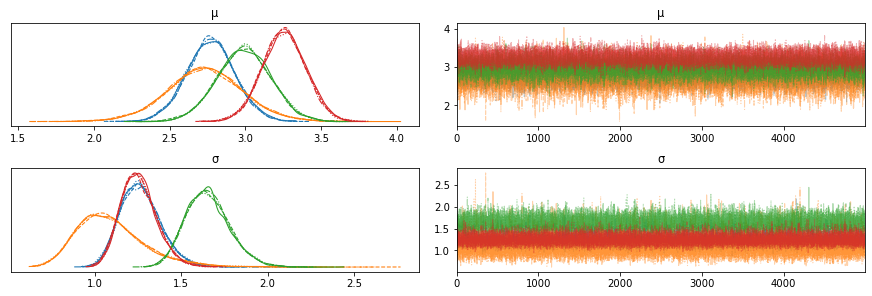

In [12]:
# earlier model
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)
    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg)

In [20]:
# found his code here (had a mistake). 
with pm.Model() as v_hyper:
    
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)
    ν = pm.Exponential('ν', 1/4) 
    
    y = pm.StudentT('y', mu=μ[idx], sd=σ[idx], nu=ν, observed=tip)
    
    trace_nu_shared = pm.sample(5000)
    y_pred_nu_shared = pm.sample_posterior_predictive(trace_nu_shared, 100)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν, σ, μ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 48 seconds.
c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>]], dtype=object)

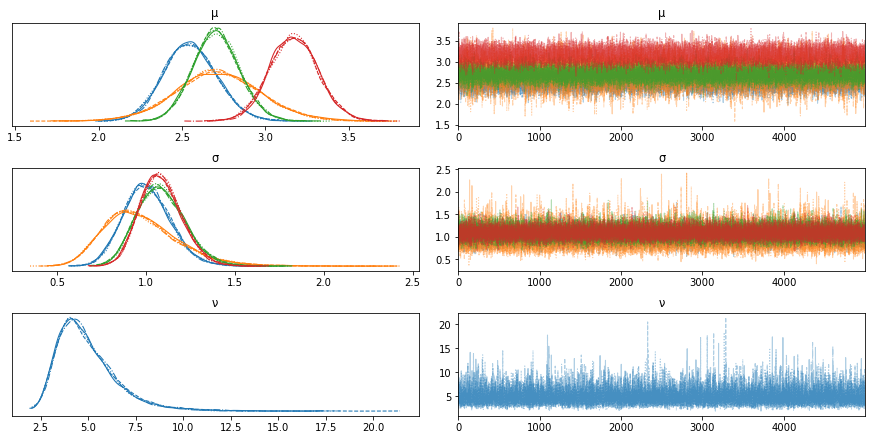

In [21]:
az.plot_trace(trace_nu_shared)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


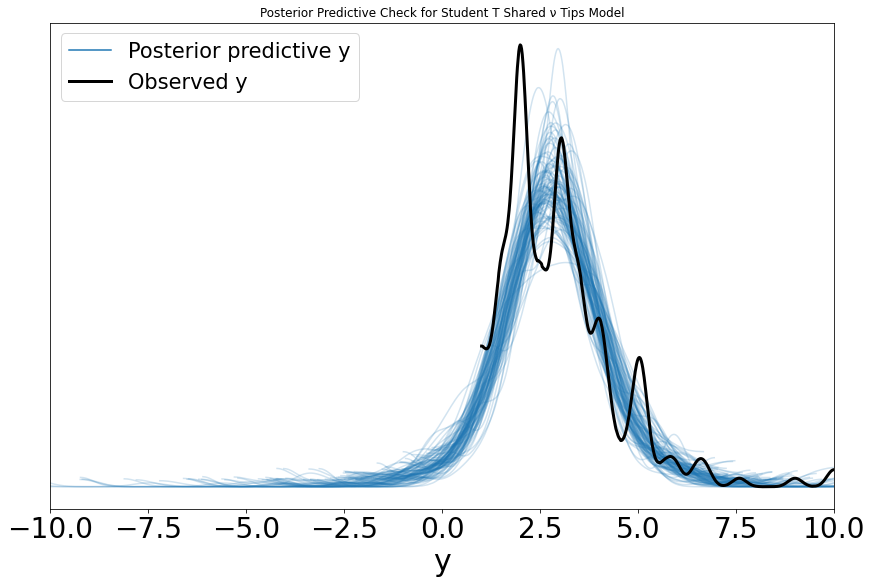

In [23]:
tips_nu_shared = az.from_pymc3(trace=trace_nu_shared, posterior_predictive=y_pred_nu_shared)
axes = az.plot_ppc(tips_nu_shared, figsize=(12,8), mean=False)
axes.set_title("Posterior Predictive Check for Student T Shared ν Tips Model")
axes.set_xlim(-10,10);

In [ ]:
# found his code here (had a mistake). 
with pm.Model() as v_nohype:
    
    μ = pm.Normal('μ', mu=0, sd=10, shape = groups)
    σ = pm.HalfNormal('σ', sd=10, shape = groups)
    ν = pm.Exponential('ν', 1/4, shape = groups) 
    
    y = pm.StudentT('y', mu=μ[idx], sd=σ[idx], nu=ν[idx], observed=tip)
    
    trace_nu_individual = pm.sample(5000)
    y_pred_nu_individual = pm.sample_posterior_predictive(trace_nu_shared, 100)

c:\users\95\anaconda3\envs\cogmod\lib\site-packages\arviz\data\io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>],
       [<AxesSubplot:title={'center':'ν'}>,
        <AxesSubplot:title={'center':'ν'}>]], dtype=object)

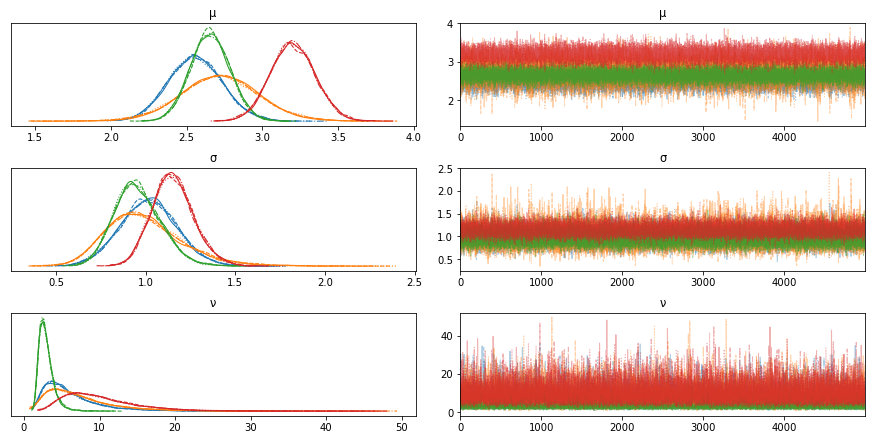

In [19]:
az.plot_trace(trace_nu_individual)

In [25]:
tips_nu_individual = az.from_pymc3(trace=trace_nu_individual, posterior_predictive=y_pred_nu_individual)
axes = az.plot_ppc(tips_nu_shared, figsize=(12,8), mean=False)
axes.set_title("Posterior Predictive Check for Student T Shared ν Tips Model")
axes.set_xlim(-10,10);

NameError: name 'y_pred_nu_individual' is not defined